In [1]:
#libraries
import numpy as np 
import pandas as pd 
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import time
import datetime
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
import random
import warnings
warnings.filterwarnings("ignore")
from functools import partial
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
import scipy as sp
from math import sqrt
from collections import Counter
from sklearn.metrics import confusion_matrix as sk_cmatrix

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display 

from sklearn.metrics import cohen_kappa_score
def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [2]:
breeds = pd.read_csv('./all/breed_labels.csv')
colors = pd.read_csv('./all/color_labels.csv')
states = pd.read_csv('./all/state_labels.csv')

train = pd.read_csv('./all/train.csv')
test = pd.read_csv('./all/test/test.csv')
sub = pd.read_csv('./all/test/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

In [3]:
train.drop('Description', axis=1).head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,dataset_type
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2,train
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0,train
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3,train
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2,train
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2,train


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Text(0.5, 1.0, 'Adoption speed classes counts')

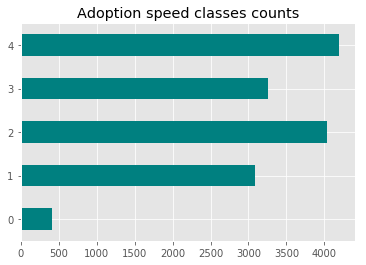

In [5]:
train['AdoptionSpeed'].value_counts().sort_index().plot('barh', color='teal')
plt.title('Adoption speed classes counts')

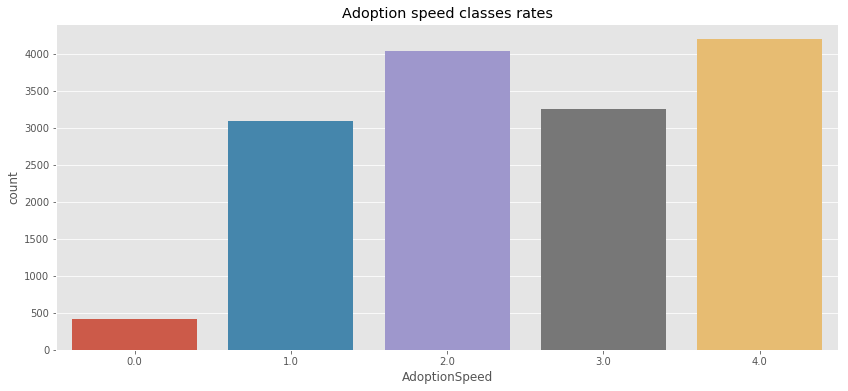

In [6]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=all_data.loc[all_data['dataset_type'] == 'train']);
plt.title('Adoption speed classes rates');
ax=g.axes

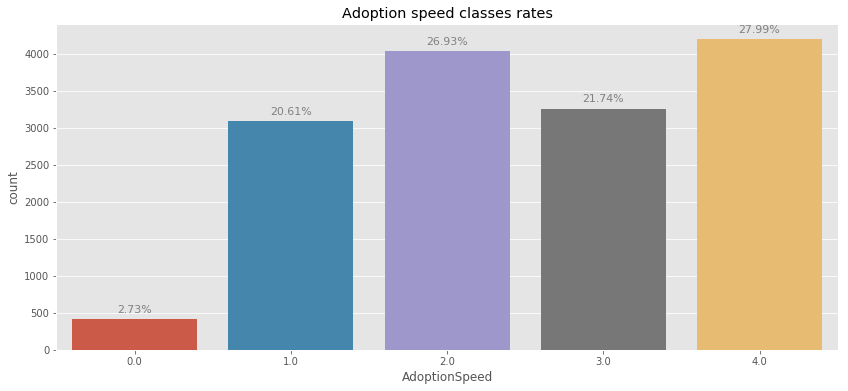

In [7]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=all_data.loc[all_data['dataset_type'] == 'train'])
plt.title('Adoption speed classes rates');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')  

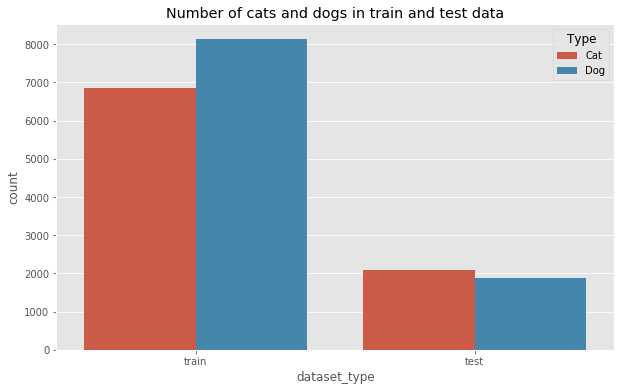

In [8]:


all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');



In [9]:
main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'AdoptionSpeed {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  


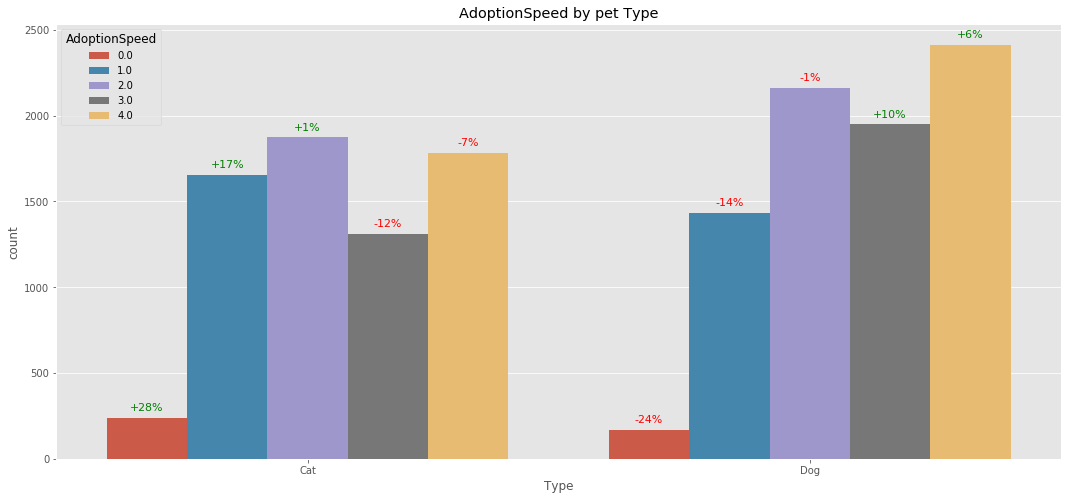

In [10]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='Type', title='by pet Type')

In [11]:
#import langdetect
#import eli5
from wordcloud import WordCloud
import lightgbm as lgb
#import xgboost as xgb
#from catboost import CatBoostClassifier
#from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
fig, ax = plt.subplots(figsize = (16, 12))
plt.subplot(1, 2, 1)
text_cat = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

In [ ]:
train['Name'].value_counts().index[:5]

In [ ]:
train['Name'] = train['Name'].fillna('Unnamed')
test['Name'] = test['Name'].fillna('Unnamed')
all_data['Name'] = all_data['Name'].fillna('Unnamed')

train['No_name'] = 0
train.loc[train['Name'] == 'Unnamed', 'No_name'] = 1
test['No_name'] = 0
test.loc[test['Name'] == 'Unnamed', 'No_name'] = 1
all_data['No_name'] = 0
all_data.loc[all_data['Name'] == 'Unnamed', 'No_name'] = 1

print(f"Rate of unnamed pets in train data: {train['No_name'].sum() * 100 / train['No_name'].shape[0]:.4f}%.")
print(f"Rate of unnamed pets in test data: {test['No_name'].sum() * 100 / test['No_name'].shape[0]:.4f}%.")

In [ ]:


pd.crosstab(train['No_name'], train['AdoptionSpeed'], normalize='index')



In [ ]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='No_name', title='and having a name')

In [ ]:


all_data[all_data['Name'].apply(lambda x: len(str(x))) < 3]['Name']



In [ ]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.title('Distribution of pets age');
train['Age'].plot('hist', label='train');
test['Age'].plot('hist', label='test');
plt.legend();

plt.subplot(1, 2, 2)
plt.title('Distribution of pets age (log)');
np.log1p(train['Age']).plot('hist', label='train');
np.log1p(test['Age']).plot('hist', label='test');
plt.legend();

In [ ]:
pd.qcut(train['Age'], 3, labels=['0-2 months', '3-5months', '6-120 months'])

In [ ]:
plt.figure(figsize=(10, 6));
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and age');

In [ ]:


data = []
for a in range(5):
    df = train.loc[train['AdoptionSpeed'] == a]

    data.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index,
        y = df['Age'].value_counts().sort_index().values,
        name = str(a)
    ))
    
layout = go.Layout(dict(title = "AdoptionSpeed trends by Age",
                  xaxis = dict(title = 'Age (months)'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=data, layout=layout), filename='basic-line')



In [ ]:
plt.figure(figsize=(20, 12));
plt.subplot(2, 2, 1)
make_count_plot(df=train, x='Vaccinated', title='Vaccinated')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Vaccinated');

plt.subplot(2, 2, 2)
make_count_plot(df=train, x='Dewormed', title='Dewormed')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Dewormed');

plt.subplot(2, 2, 3)
make_count_plot(df=train, x='Sterilized', title='Sterilized')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Sterilized');

plt.subplot(2, 2, 4)
make_count_plot(df=train, x='Health', title='Health')
plt.xticks([0, 1, 2], ['Healthy', 'Minor Injury', 'Serious Injury']);
plt.title('AdoptionSpeed and Health');

plt.suptitle('Adoption Speed and health conditions');

In [ ]:
def make_factor_plot(df, x, col, title, main_count=main_count, hue=None, ann=True, col_wrap=4):
    """
    Plotting countplot.
    Making annotations is a bit more complicated, because we need to iterate over axes.
    """
    if hue:
        g = sns.factorplot(col, col=x, data=df, kind='count', col_wrap=col_wrap, hue=hue);
    else:
        g = sns.factorplot(col, col=x, data=df, kind='count', col_wrap=col_wrap);
    plt.subplots_adjust(top=0.9);
    plt.suptitle(title);
    ax = g.axes
    plot_dict = prepare_plot_dict(df, x, main_count)
    if ann:
        for a in ax:
            for p in a.patches:
                text = f"{plot_dict[p.get_height()]:.0f}%" if plot_dict[p.get_height()] < 0 else f"+{plot_dict[p.get_height()]:.0f}%"
                a.annotate(text, (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='green' if plot_dict[p.get_height()] > 0 else 'red', rotation=0, xytext=(0, 10),
                     textcoords='offset points') 

In [ ]:
train['health'] = train['Vaccinated'].astype(str) + '_' + train['Dewormed'].astype(str) + '_' + train['Sterilized'].astype(str) + '_' + train['Health'].astype(str)
test['health'] = test['Vaccinated'].astype(str) + '_' + test['Dewormed'].astype(str) + '_' + test['Sterilized'].astype(str) + '_' + test['Health'].astype(str)


make_factor_plot(df=train.loc[train['health'].isin(list(train.health.value_counts().index[:5]))], x='health', col='AdoptionSpeed', title='Counts of pets by main health conditions and Adoption Speed')